# Model validation water levels

Note: this notebook requires the model output data

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

In [1]:
import mikeio
import modelskill as ms
import matplotlib.pyplot as plt 
import helper as h

In [2]:
ms.options.metrics.list = ["rmse", "mae", "cc", "si", "r2"]

Instead of reading the entire dfsu (`Area.dfsu`), we can simply load the outputted points (dfs0) since they correspond to the locations we have observations from.

In [3]:
mr_fldr = "../output/"    
# mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
save_png = False if "sample" in mr_fldr else True
fig_fldr = "../figures/" 


Model results data are stored in a dfs0 file. We can use [MIKE IO](https://dhi.github.io/mikeio) read the data to a MIKE IO Dataset.

Note: The first two spin-up days are excluded.

In [4]:
ds = mikeio.read(f"{mr_fldr}Points.dfs0", items="*Surf*", time = slice("2022-01-03", None))
ds.items

[NWA: Surface elevation <Surface Elevation> (meter),
 IJVA: Surface elevation <Surface Elevation> (meter),
 DDW1A: Surface elevation <Surface Elevation> (meter),
 F3platform: Surface elevation <Surface Elevation> (meter),
 K13a: Surface elevation <Surface Elevation> (meter),
 Europlatform: Surface elevation <Surface Elevation> (meter),
 J61: Surface elevation <Surface Elevation> (meter),
 Dover: Surface elevation <Surface Elevation> (meter),
 Lowestoft: Surface elevation <Surface Elevation> (meter),
 Cromer: Surface elevation <Surface Elevation> (meter)]

## Compare to water level station observations

The [ModelSkill package](https://dhi.github.io/modelskill/) can be used to compare model results with observations.

In [5]:
wllist = h.get_wl_point_obs()

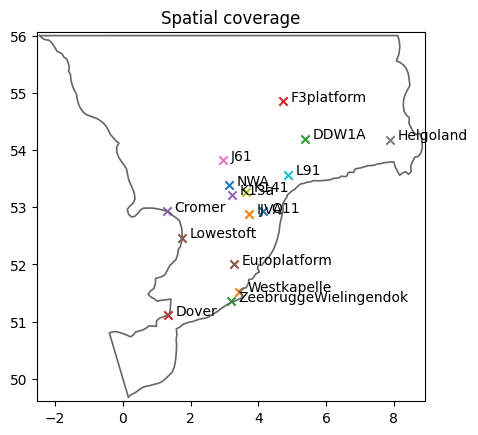

In [6]:
msh = mikeio.open("../input/Mesh_8000_elems_HD_v2.mesh")
ms.plotting.spatial_overview(wllist, mod=msh);

Match the right model result timeseries and observation. Also, remove the bias (different vertical datum).

In [7]:
mr_fn = f"{mr_fldr}Area.dfsu"
mr = ms.DfsuModelResult(mikeio.read(mr_fn,time=slice("2022-01-03","2023-12-31"))[0], name="MIKE21")
cmps = []
for o in wllist:
    # mr = ms.PointModelResult(ds[o.name+": Surface elevation"], name="MIKE21")
    try:
        cmp = ms.match(obs=o, mod=mr)
    except Exception as e:
        print(e)
    cmps.append(cmp.remove_bias())
cc = ms.ComparerCollection(cmps)

## Skill table

In [8]:
cc.skill().round(3)

,n,rmse,mae,cc,si,r2
observation,,,,,,
NWA,79352,0.143,0.114,0.960,0.350,0.915
IJVA,80117,0.140,0.111,0.918,0.488,0.841
DDW1A,29713,0.144,0.101,0.936,0.426,0.875
F3platform,104773,0.133,0.108,0.862,0.662,0.718
K13a,101374,0.156,0.120,0.941,0.416,0.883
Europlatform,103533,0.201,0.142,0.944,0.394,0.887
J61,104827,0.171,0.126,0.956,0.363,0.906
Helgoland,104827,0.259,0.221,0.958,0.344,0.912
K141,104629,0.142,0.108,0.958,0.364,0.911


## Example timeseries

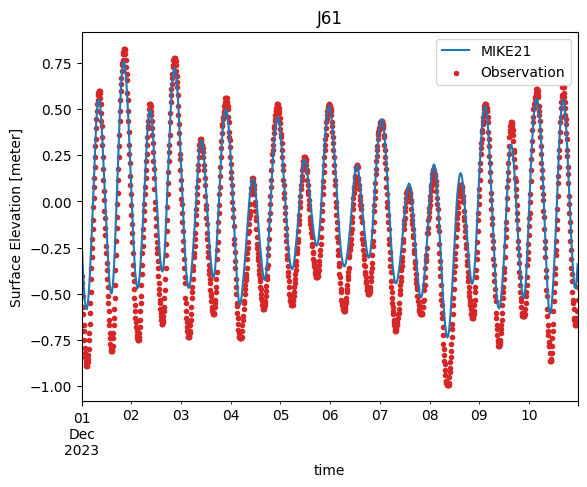

In [9]:
t_plot = slice("2023-12-01","2023-12-10") if "2023-12-01" in ds.time else slice(None, None)
cc["J61"].sel(time=t_plot).plot.timeseries();

## Scatter plots

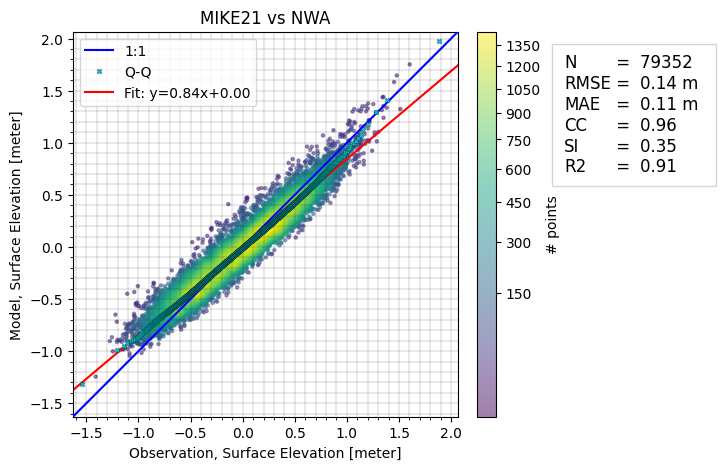

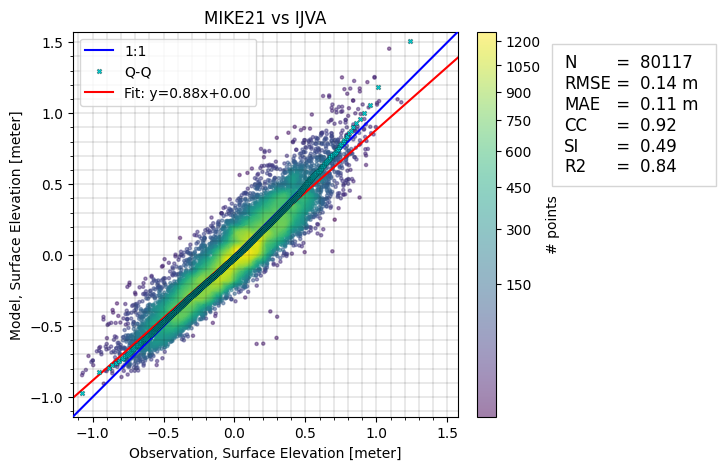

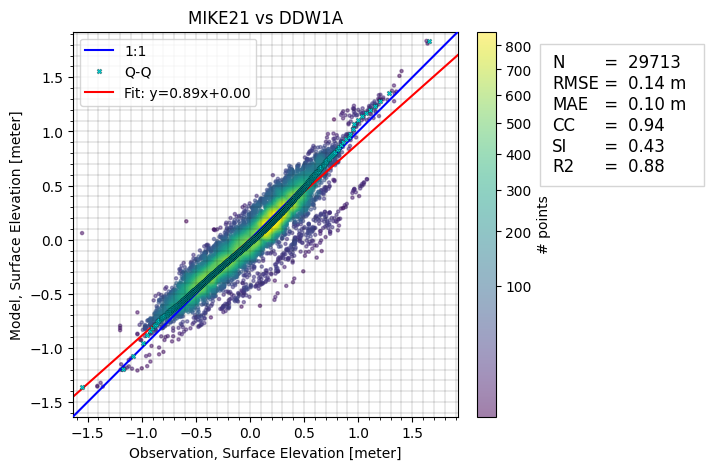

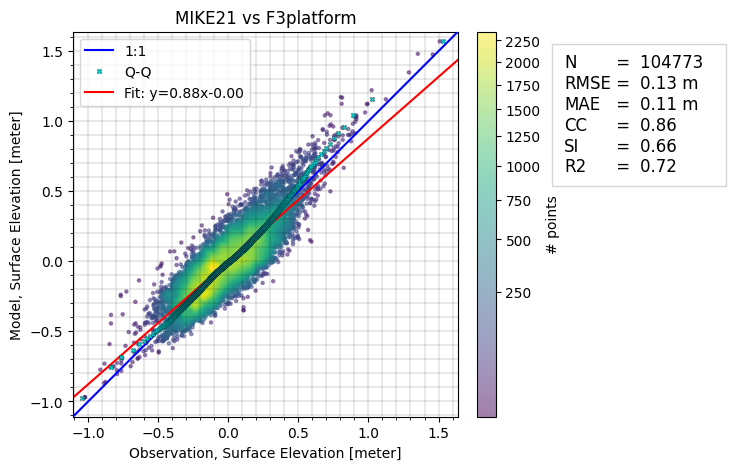

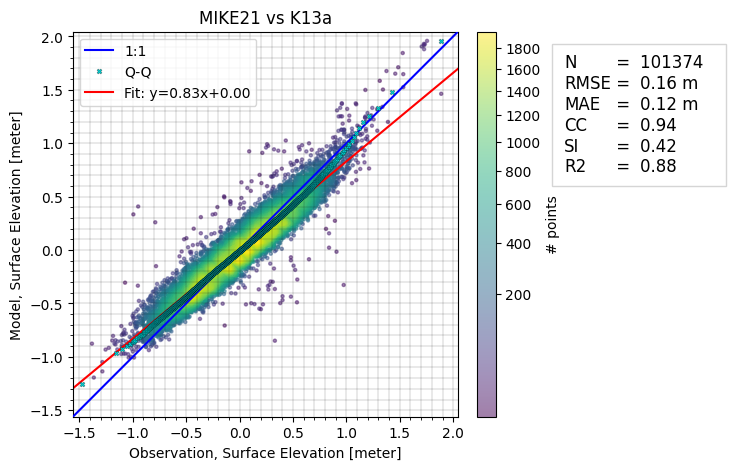

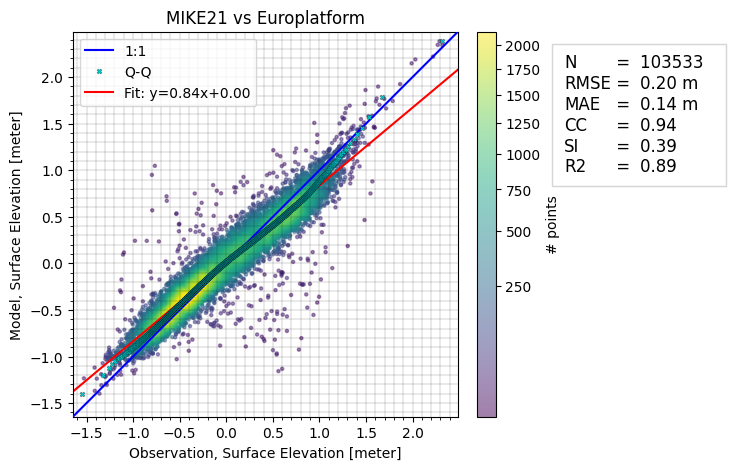

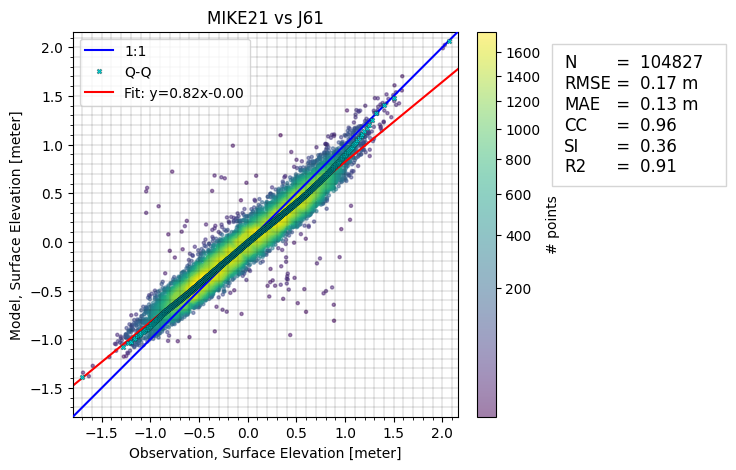

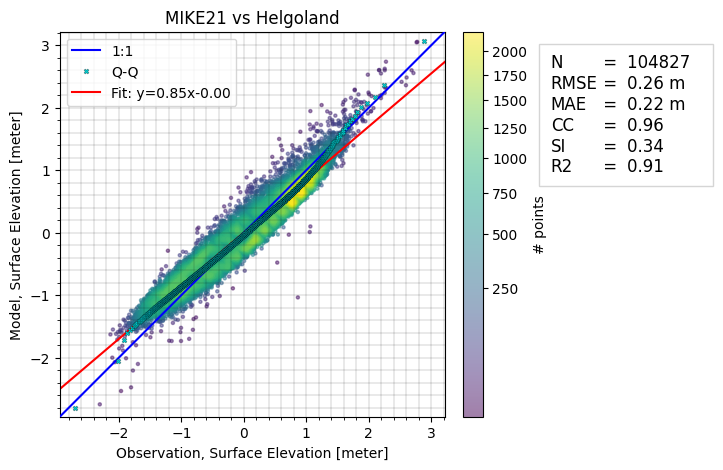

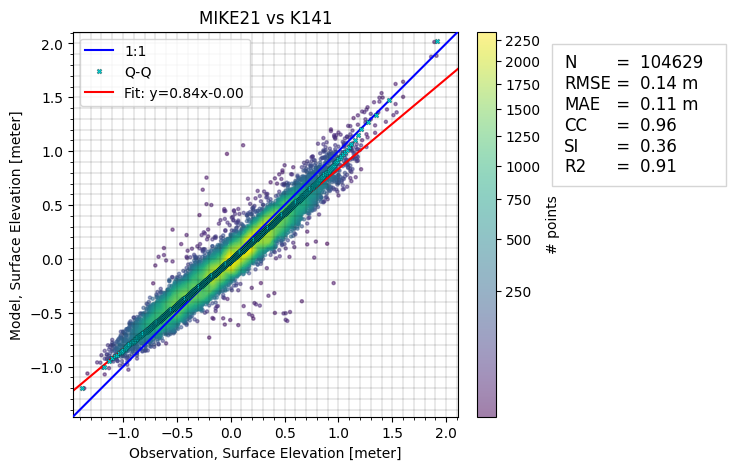

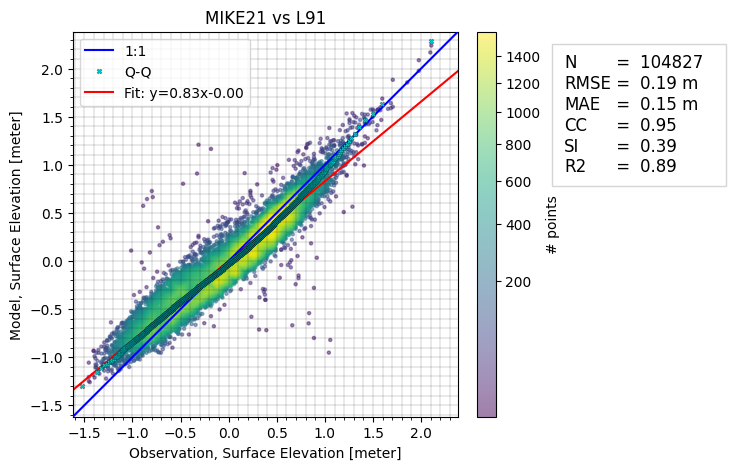

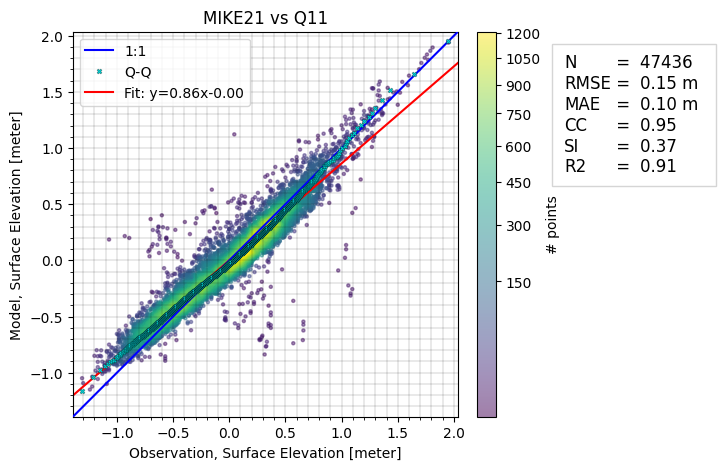

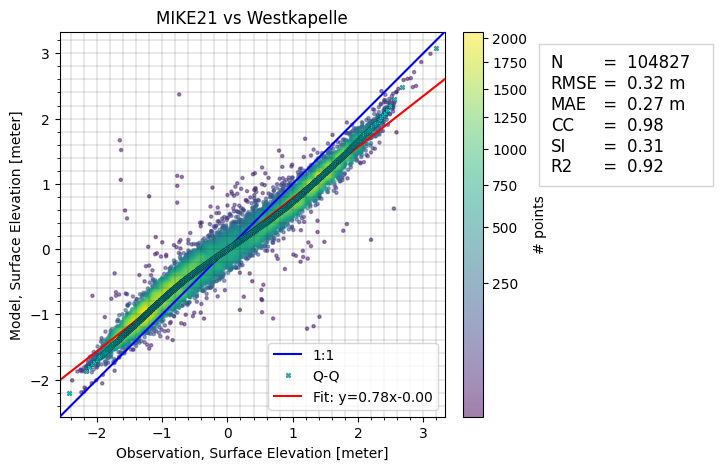

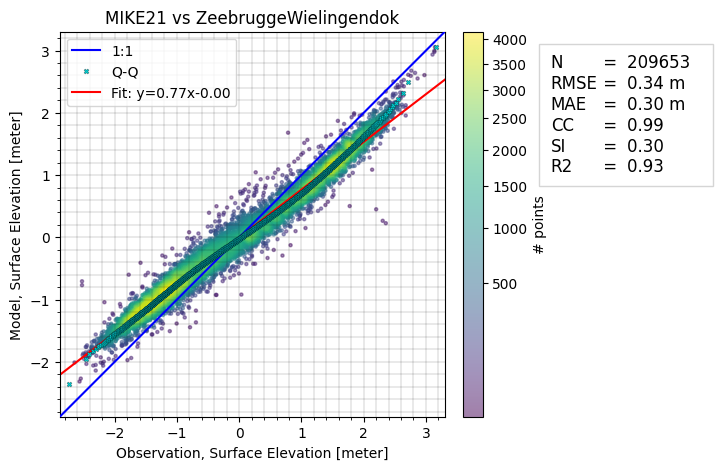

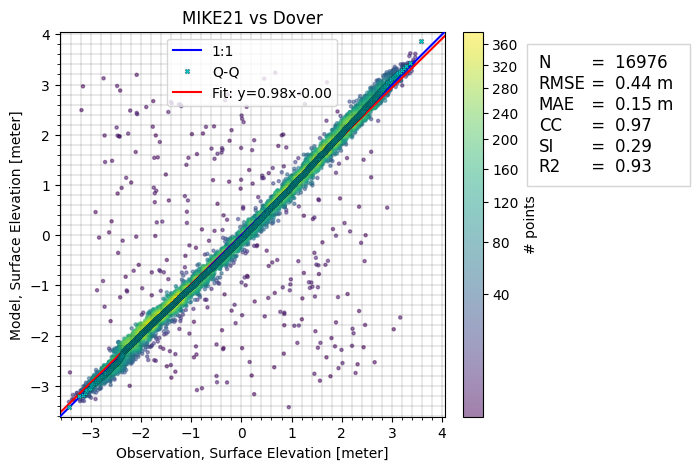

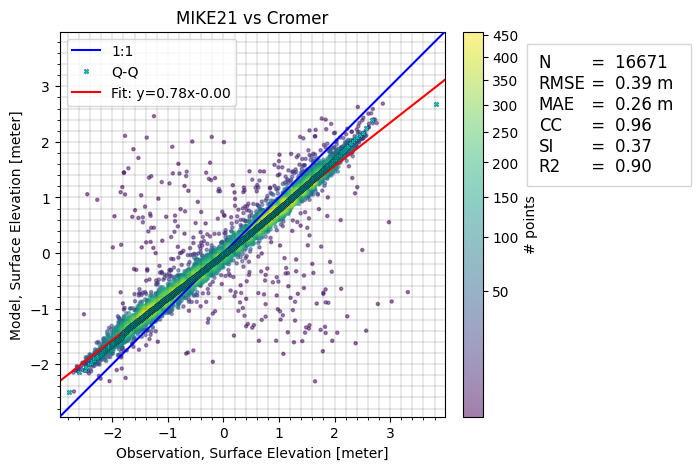

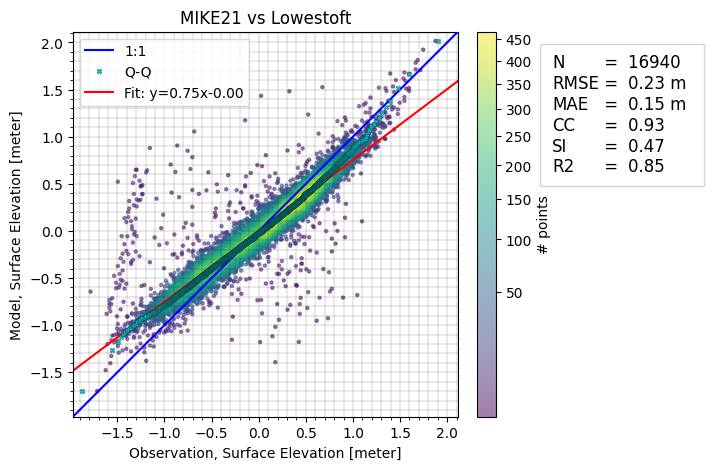

In [10]:
n_points_shown = 10000
for cmp in cc:
    cmp.plot.scatter(skill_table=True, show_points=n_points_shown, figsize=(6,5), bins=40);
    if save_png:
        plt.savefig(f"{fig_fldr}modelskill_comparison_{cmp.name}.png", bbox_inches='tight');